In [163]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import librosa
import sys
import torch
import random
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import statistics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import preprocessing
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.utils.data as data_utils
import os
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from pomegranate.distributions import Normal
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.hmm import DenseHMM
#from pomegranate import *
import itertools
import matplotlib.pyplot as plt

In [17]:
import os
from glob import glob

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


def parse_free_digits(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, "*.wav"))
    fnames = [f.split("/")[1].split(".")[0].split("_") for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        wav, _ = librosa.core.load(f, sr=None)

        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers


def extract_features(wavs, n_mfcc=6, Fs=8000):
    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [
        librosa.feature.mfcc(
            y=wav, sr=Fs, n_fft=window, hop_length=window - step, n_mfcc=n_mfcc
        ).T
        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames


def split_free_digits(frames, ids, speakers, labels):
    print("Splitting in train test split using the default dataset split")
    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4"]

    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test


def make_scale_fn(X_train):
    # Standardize on train data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(X_train))
    print("Normalization will be performed using mean: {}".format(scaler.mean_))
    print("Normalization will be performed using std: {}".format(scaler.scale_))

    def scale(X):
        scaled = []

        for frames in X:
            scaled.append(scaler.transform(frames))
        return scaled

    return scale


def parser(directory, n_mfcc=6):
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames, ids, speakers, y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [36]:
###Βήμα 9
X_train, X_test, y_train, y_test, spk_train, spk_test = parser('recordings/') #parse recordings/

Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:12<00:00, 241.32it/s]

Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split


In [158]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train) #80% train and 20% test
print("If using all data to calculate normalization statistics")
scale_fn = make_scale_fn(X_train + X_val + X_test)
print("If using X_train + X_dev to calculate normalization statistics")
scale_fn = make_scale_fn(X_train + X_val)
print("If using X_train to calculate normalization statistics")
scale_fn = make_scale_fn(X_train)
X_train = scale_fn(X_train)
X_val = scale_fn(X_val)
X_test = scale_fn(X_test)

If using all data to calculate normalization statistics
Normalization will be performed using mean: [-0.00315184 -0.00219126 -0.00208666 -0.00229175 -0.00110924 -0.00839829]
Normalization will be performed using std: [0.99907301 0.99933939 0.99942117 0.99933838 0.99779955 1.0051149 ]
If using X_train + X_dev to calculate normalization statistics
Normalization will be performed using mean: [-7.30438267e-09  3.20663234e-09  2.82464743e-09 -1.24811691e-08
  1.59798781e-08  9.46484711e-09]
Normalization will be performed using std: [1. 1. 1. 1. 1. 1.]
If using X_train to calculate normalization statistics
Normalization will be performed using mean: [-0.00880272 -0.00739624 -0.00019971 -0.0089094   0.00142427  0.00343057]
Normalization will be performed using std: [1.00307951 1.0021389  0.98917389 1.00198806 1.00032236 0.99614407]


In [160]:
#check number of samples for digit for train set and test set and then print the results
train_number = []
test_number = []
val_number = []
y_t = np.array(y_train)
y_te = np.array(y_test)
y_v = np.array(y_val)
for i in range(0,10):
    train_number.append((np.where(y_t == i)[0]).shape[0])
print("For train set:")
for i in range(len(train_number)):                          
    print('Number of samples for digit {}:'.format(i),train_number[i])
for i in range(0,10):
    val_number.append((np.where(y_v == i)[0]).shape[0])
print("For validation set:")
for i in range(len(val_number)):                          
    print('Number of samples for digit {}:'.format(i),val_number[i])
print("For test set:")
for i in range(0,10):
    test_number.append((np.where(y_te == i)[0]).shape[0])
for i in range(len(test_number)):                          
    print('Number of samples for digit {}:'.format(i),test_number[i])

For train set:
Number of samples for digit 0: 138
Number of samples for digit 1: 138
Number of samples for digit 2: 138
Number of samples for digit 3: 138
Number of samples for digit 4: 138
Number of samples for digit 5: 138
Number of samples for digit 6: 139
Number of samples for digit 7: 139
Number of samples for digit 8: 138
Number of samples for digit 9: 138
For validation set:
Number of samples for digit 0: 35
Number of samples for digit 1: 35
Number of samples for digit 2: 34
Number of samples for digit 3: 35
Number of samples for digit 4: 35
Number of samples for digit 5: 35
Number of samples for digit 6: 34
Number of samples for digit 7: 34
Number of samples for digit 8: 35
Number of samples for digit 9: 34
For test set:
Number of samples for digit 0: 30
Number of samples for digit 1: 30
Number of samples for digit 2: 30
Number of samples for digit 3: 30
Number of samples for digit 4: 30
Number of samples for digit 5: 30
Number of samples for digit 6: 30
Number of samples for d

In [161]:
###Βήμα 10
n_states = 2  # the number of HMM states
n_mixtures = 2  # the number of Gaussians
gmm = True  # whether to use GMM or plain Gaussian
covariance_type = "diag"  # Use diagonal covariange


# Gather data separately for each digit
def gather_in_dic(X, labels):
    dic = {}
    for dig in set(labels):
        x = [X[i] for i in range(len(labels)) if labels[i] == dig]
        lengths = [len(i) for i in x]
        y = [dig for _ in range(len(x))]
        dic[dig] = (x, lengths, y)
    return dic

train_dic = gather_in_dic(X_train, y_train)
val_dic = gather_in_dic(X_val, y_val)
test_dic = gather_in_dic(X_test, y_test)
labels = list(set(y_train))

In [144]:
#create GMM HMM model with the following parameters: X which will be one digit, states, Gaussian distributions, whether to use GMM or not
class GMM_HMM:
    def __init__(self, X, n_states=2, n_mixtures=2, max_iters=5,gmm=True):
        self.X = X                                                        
        self.n_states = n_states                                         
        self.n_mixtures = n_mixtures  
        self.max_iters = max_iters                                   
        self.gmm = gmm 
        self.trans_matrix = np.zeros((self.n_states, self.n_states),dtype=np.float32)
        for i in range(self.n_states):
            for j in range(self.n_states):
                if i + 1 == j or i == j:
                    self.trans_matrix[i, j] = 0.5
        self.trans_matrix[self.n_states - 1][self.n_states - 1] = 1
        self.start = np.zeros(self.n_states,dtype=np.float32)
        self.start[0] = 1
        self.end = np.zeros(self.n_states, dtype=np.float32)
        self.end[-1] = 1          
        self.dists = [] 
        self.distributions = [Normal() for i in range(n_mixtures)]                                                # list of probability distributions for the HMM states
        for i in range(self.n_states):
            if n_mixtures > 1:
                a = GeneralMixtureModel(self.distributions, verbose=False).fit(np.concatenate(X))
            else:
                a = Normal().fit(np.concatenate(X))
            self.dists.append(a)
        self.model = DenseHMM(self.dists, self.trans_matrix, self.start, self.end, self.max_iters, verbose=False)

    def fit(self, X):
        self.data = [x.astype(np.float32) for x in X]
        self.model.fit(self.data) #train hmm model
        return self
    
    def predict(self, X):
        prediction = self.model.log_probability(X) # predict logp 
        return prediction

In [128]:
#initialize one gmm-hmm for every digit
def initialize_gmm_hmm(train_dic, n_states, n_mixtures, max_iters):
    hmm_list = []
    for i in range(10):
        X, _, _ = train_dic[i]
        hmm = GMM_HMM(X, n_states, n_mixtures, max_iters)
        hmm_list.append(hmm)
    return hmm_list
    

In [129]:
hmms = initialize_gmm_hmm(train_dic, 4, 4, 5) #run the function 

[1] Improvement: 237.77734375, Time: 0.00957s
[2] Improvement: 77.94140625, Time: 0.00385s
[3] Improvement: 72.9453125, Time: 0.002904s
[4] Improvement: 64.35546875, Time: 0.002655s
[5] Improvement: 30.4296875, Time: 0.00274s
[6] Improvement: 13.515625, Time: 0.00313s
[7] Improvement: 8.5390625, Time: 0.002613s
[8] Improvement: 6.41015625, Time: 0.002464s
[9] Improvement: 5.046875, Time: 0.002341s
[10] Improvement: 4.02734375, Time: 0.0022s
[11] Improvement: 3.1875, Time: 0.002494s
[12] Improvement: 2.51171875, Time: 0.002632s
[13] Improvement: 1.984375, Time: 0.002684s
[14] Improvement: 1.57421875, Time: 0.00278s
[15] Improvement: 1.26953125, Time: 0.002638s
[16] Improvement: 1.04296875, Time: 0.002332s
[17] Improvement: 0.8984375, Time: 0.002443s
[18] Improvement: 0.80859375, Time: 0.002602s
[19] Improvement: 0.76953125, Time: 0.002761s
[20] Improvement: 0.75390625, Time: 0.002542s
[21] Improvement: 0.7578125, Time: 0.002312s
[22] Improvement: 0.79296875, Time: 0.002408s
[23] Improve

In [130]:
#Βήμα 11
#train gmm-hmm for every digit
def train_gmm_hmm(hmms, X):
    for i in range(10):
        X, _, _ = train_dic[i]
        hmms[i].fit(X)

In [131]:
train_gmm_hmm(hmms, train_dic)

[1] Improvement: 571.84375, Time: 0.203s
[2] Improvement: 2032.72265625, Time: 0.1783s
[3] Improvement: 912.6796875, Time: 0.1855s
[4] Improvement: 952.09765625, Time: 0.1801s
[5] Improvement: 191.609375, Time: 0.1914s
[6] Improvement: 16.734375, Time: 0.2326s
[7] Improvement: 4.984375, Time: 0.1892s
[8] Improvement: 2.24609375, Time: 0.1817s
[9] Improvement: 1.28515625, Time: 0.1861s
[10] Improvement: 0.859375, Time: 0.1882s
[11] Improvement: 0.64453125, Time: 0.1867s
[12] Improvement: 0.515625, Time: 0.1853s
[13] Improvement: 0.4765625, Time: 0.1825s
[14] Improvement: 0.48046875, Time: 0.183s
[15] Improvement: 0.62109375, Time: 0.1783s
[16] Improvement: 0.87890625, Time: 0.1812s
[17] Improvement: 0.9296875, Time: 0.1786s
[18] Improvement: 0.85546875, Time: 0.1816s
[19] Improvement: 0.93359375, Time: 0.1812s
[20] Improvement: 1.19140625, Time: 0.1819s
[21] Improvement: 1.6171875, Time: 0.178s
[22] Improvement: 2.3515625, Time: 0.1797s
[23] Improvement: 3.57421875, Time: 0.1792s
[24] I

In [134]:
#Βήμα 12
def evaluate(hmms, dic, labels):
    pred, true = [], []
    for dig in labels:
        X, _, _ = dic[dig]
        for sample in X:
            sample = np.expand_dims(sample, 0)
            logps = []
            for j in range(10):
                logp = hmms[j].predict(sample) # use the hmm.log_probability function
                logps.append(logp) #append the log
            logps = np.array(logps) #create numpy array 
            pred.append(np.argmax(logps)) #append the one with the highest probability
            true.append(dig)
    pred = np.array(pred)
    true = np.array(true)
    correct = (pred == true)
    accuracy = correct.sum() / correct.size
    return(accuracy)

In [133]:
print(evaluate(hmms, test_dic, labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 3, 3, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 3, 6, 6, 3, 7, 6, 6, 8, 6, 6, 6, 6, 6, 6, 3, 8, 6, 6, 6, 6, 7, 7, 7, 2, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [155]:
def grid_search(train_dic, val_dic, test_dic,n_states,n_mixtures):
    best_accuracy = 0.0
    best_state = 0
    best_mixture = 0
    for mixture in n_mixtures:
        for state in n_states:
            hmms = initialize_gmm_hmm(train_dic, state, mixture, 5) #run the function 
            train_gmm_hmm(hmms, train_dic)
            accuracy = evaluate(hmms, val_dic, labels)
            if (accuracy>best_accuracy):
                best_accuracy = accuracy
                best_state = state
                best_mixture = mixture
            print('HHM with number of states ' + str(state) + ' and number of mixtures ' + str(mixture) + ' has accuracy ' + str(accuracy))
    print('HHM with number of states ' + str(best_state) + ' and number of mixtures ' + str(best_mixture) + ' has best accuracy ' + str(best_accuracy))
    hmms = initialize_gmm_hmm(train_dic, best_state, best_mixture, 5) #run the function 
    train_gmm_hmm(hmms, train_dic)
    test_accuracy = evaluate(hmms, test_dic, labels)
    print('On Test dataset: HHM with number of states ' + str(best_state) + ' and number of mixtures ' + str(best_mixture) + ' has accuracy ' + str(test_accuracy))
    return(best_accuracy, best_state, best_mixture)


In [162]:
best_accuracy, best_state, best_mixture = grid_search(train_dic, val_dic, test_dic,[1,2,3,4],[1,2,3,4,5])

HHM with number of states 1 and number of mixtures 1 has accuracy 0.7832369942196532
HHM with number of states 2 and number of mixtures 1 has accuracy 0.8439306358381503
HHM with number of states 3 and number of mixtures 1 has accuracy 0.8930635838150289
HHM with number of states 4 and number of mixtures 1 has accuracy 0.9017341040462428
HHM with number of states 1 and number of mixtures 2 has accuracy 0.8294797687861272
HHM with number of states 2 and number of mixtures 2 has accuracy 0.838150289017341
HHM with number of states 3 and number of mixtures 2 has accuracy 0.8294797687861272
HHM with number of states 4 and number of mixtures 2 has accuracy 0.8352601156069365
HHM with number of states 1 and number of mixtures 3 has accuracy 0.8526011560693642
HHM with number of states 2 and number of mixtures 3 has accuracy 0.8728323699421965
HHM with number of states 3 and number of mixtures 3 has accuracy 0.8988439306358381
HHM with number of states 4 and number of mixtures 3 has accuracy 

In [164]:
#Βήμα 13
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [165]:
#train best model for creating the cm
hmms = initialize_gmm_hmm(train_dic, 2, 5, 5) #run the function 
train_gmm_hmm(hmms, train_dic)

In [190]:
def create_cm(hmms, dic, labels, title):
    cm = np.zeros((10,10), dtype=int)
    for dig in labels:
        X, _, y = dic[dig]
        for sample in X:
            sample = np.expand_dims(sample, 0)
            logps = []
            for j in range(10):
                logp = hmms[j].predict(sample) # use the hmm.log_probability function
                logps.append(logp) #append the log
            logps = np.array(logps) #create numpy array 
            prediction = (np.argmax(logps)) #append the one with the highest probability
            cm[dig][prediction] += 1
    #plot_confusion_matrix(cm,labels, normalize=False, title=title)
    plot_confusion_matrix(cm,labels, normalize=True, title=title)

Normalized confusion matrix
[[0.94285714 0.02857143 0.         0.         0.02857143 0.
  0.         0.         0.         0.        ]
 [0.         0.97142857 0.         0.         0.         0.
  0.         0.         0.         0.02857143]
 [0.02941176 0.         0.97058824 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.08571429 0.         0.14285714 0.68571429 0.         0.
  0.         0.         0.08571429 0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.94285714
  0.         0.02857143 0.         0.02857143]
 [0.         0.         0.         0.20588235 0.         0.
  0.61764706 0.02941176 0.14705882 0.        ]
 [0.         0.         0.         0.02941176 0.         0.
  0.         0.97058824 0.         0.        ]
 [0.         0.         0.         0.02857143 0.         0.
  0.         0.         0.97142857 0.        ]
 

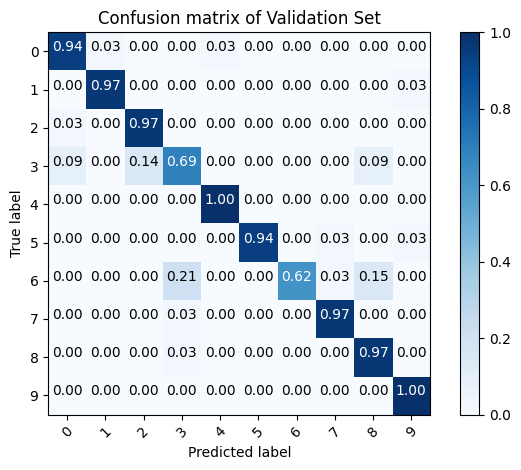

In [191]:
create_cm(hmms, val_dic, labels, "Confusion matrix of Validation Set")

Normalized confusion matrix
[[0.9        0.03333333 0.06666667 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.96666667 0.         0.         0.03333333 0.
  0.         0.         0.         0.        ]
 [0.         0.03333333 0.96666667 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.13333333 0.8        0.         0.03333333
  0.03333333 0.         0.         0.        ]
 [0.         0.03333333 0.         0.         0.96666667 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.03333333 0.         0.03333333
  0.7        0.03333333 0.16666667 0.03333333]
 [0.         0.         0.         0.         0.         0.
  0.         0.93333333 0.         0.06666667]
 [0.         0.         0.         0.         0.         0.03333333
  0.         0.         0.933333

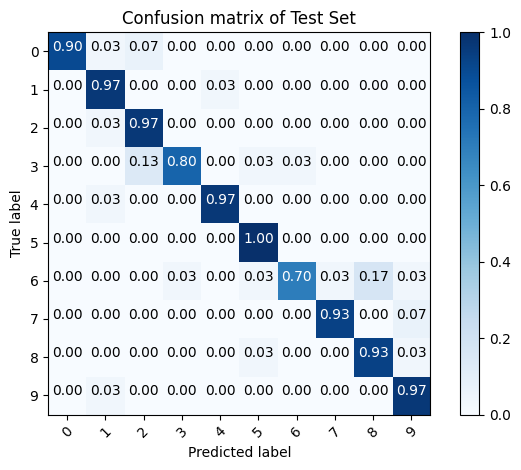

In [192]:
create_cm(hmms, test_dic, labels, "Confusion matrix of Test Set")

In [194]:
#Βήμα 14
class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
        feats: Python list of numpy arrays that contain the sequence features.
               Each element of this list is a numpy array of shape seq_length x feature_dimension
        labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        # TODO: YOUR CODE HERE
        self.lengths = [len(i) for i in feats]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype("int64")

    def zero_pad_and_stack(self, x: np.ndarray) -> np.ndarray:
        """
        This function performs zero padding on a list of features and forms them into a numpy 3D array
        returns
            padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # TODO: YOUR CODE HERE
        # --------------- Insert your code here ---------------- #
        max_sequence_length=max([len(sequence) for sequence in x])
        for sequence in x:
            padded.append(np.pad(sequence, ((0,max_sequence_length-sequence.shape[0]), (0,0)), mode = "constant"))
        padded=np.array(padded)
        return padded

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)

In [196]:
def create_dataloaders(batch_size, X_train, y_train, X_test, y_test, X_val, y_val):
    trainset = FrameLevelDataset(X_train, y_train)
    validset = FrameLevelDataset(X_val, y_val)
    testset = FrameLevelDataset(X_test, y_test)
    # TODO: YOUR CODE HERE
    # Initialize the training, val and test dataloaders (torch.utils.data.DataLoader)
    train_dataloader = torch.utils.data.DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)    
    val_dataloader = torch.utils.data.DataLoader(dataset=validset,batch_size=batch_size,shuffle=True)    
    test_dataloader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=True)    
    return train_dataloader, val_dataloader, test_dataloader


In [197]:
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(16, X_train, y_train, X_test, y_test, X_val, y_val)

In [208]:
class BasicLSTM(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size,
        output_dim,
        num_layers=2,
        bidirectional=False,
        dropout=0.0,
    ):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.dropout = dropout
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        # TODO: YOUR CODE HERE
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional, dropout=self.dropout) #lstm definition
        self.linear = nn.Linear(self.feature_size, output_dim) #last layer will be a linear layer
    def forward(self, x, lengths):
        """
        x : 3D numpy array of dimension N x L x D
            N: batch index
            L: sequence index
            D: feature index

        lengths: N x 1
        """

        # TODO: YOUR CODE HERE
        # --------------- Insert your code here ---------------- #

        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        if self.bidirectional:
          factor=2
        else:
          factor=1
        h_0 = torch.zeros(self.num_layers*factor, x.size(0), self.hidden_size) 
        c_0 = torch.zeros(self.num_layers*factor, x.size(0), self.hidden_size) 
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  
        last_timestep_output=self.last_timestep(output, lengths, self.bidirectional)
        last_outputs = self.linear(last_timestep_output)
        return last_outputs

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
        Returns the last output of the LSTM taking into account the zero padding
        """
        # TODO: READ THIS CODE AND UNDERSTAND WHAT IT DOES
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        # TODO: READ THIS CODE AND UNDERSTAND WHAT IT DOES
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # TODO: READ THIS CODE AND UNDERSTAND WHAT IT DOES
        # Index of the last output for each sequence.
        idx = (
            (lengths - 1)
            .view(-1, 1)
            .expand(outputs.size(0), outputs.size(2))
            .unsqueeze(1)
        )
        return outputs.gather(1, idx).squeeze()

In [209]:
#initialize lstm model
input_dim = 10
output_dim = 10  # number of digits
rnn_size = 64
num_layers = 2
bidirectional = False
dropout = 0
patience = 3
epochs = 15
lr = 1e-3
weight_decay = 0.0
model = BasicLSTM(input_dim, rnn_size, output_dim, num_layers)             
criterion = nn.CrossEntropyLoss()                                         #  we choose cross entropy loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)            # we choose adam optimizer

In [219]:
def training_loop(model, train_dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for num_batch, batch in enumerate(train_dataloader):
        features, labels, lengths = batch
        optimizer.zero_grad() # zero grads in the optimizer
        outputs = model(features,lengths)  # run forward pass                               
        loss = criterion(outputs, labels)  # calculate loss 
        loss.backward()   # compute gradient   
        optimizer.step() 
        running_loss += loss.item()
        num_batches += 1
    train_loss = running_loss / num_batches
    return train_loss


def evaluation_loop(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    num_batches = 0
    y_pred = torch.empty(0, dtype=torch.int64)
    y_true = torch.empty(0, dtype=torch.int64)
    with torch.no_grad():
        for num_batch, batch in enumerate(dataloader):
            features, labels, lengths = batch

            # TODO: YOUR CODE HERE
            # Run forward pass
            logits = model(features,lengths)
            # calculate loss
            loss = criterion(logits,labels)
            running_loss += loss.item()
            # Predict
              
            outputs = torch.argmax(logits,dim=1)    # Calculate the argmax of logits
            y_pred = torch.cat((y_pred, outputs))
            y_true = torch.cat((y_true, labels))
            num_batches += 1
    valid_loss = running_loss / num_batches
    return valid_loss, y_pred, y_true


def train(train_dataloader, val_dataloader, criterion, validate=False, weight_decay=0.0, dropout=0, bidirectional=False):
    # TODO: YOUR CODE HERE
    input_dim = 10
    output_dim = 10  # number of digits
    rnn_size = 64
    num_layers = 2
    patience = 3
    epochs = 15
    lr = 1e-3
    input_dim = train_dataloader.dataset.feats.shape[-1]
    model = BasicLSTM(
        input_dim,
        rnn_size,
        output_dim,
        num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
    )
    # TODO: YOUR CODE HERE
    # Initialize AdamW
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)    

    #early_stopping = EarlyStopping(patience, mode="min")
    for epoch in range(epochs):
        training_loss = training_loop(model, train_dataloader, optimizer, criterion)
        if validate:
            valid_loss, y_pred, y_true = evaluation_loop(model, val_dataloader, criterion)
            y_pred = y_pred.numpy()
            y_true = y_true.numpy()
            valid_accuracy = np.sum(y_pred == y_true)/len(y_pred)
            print(
                "Epoch {}: train loss = {}, valid loss = {}, valid acc = {}".format(
                    epoch, training_loss, valid_loss, valid_accuracy
                )
            )
        else:
            print(
                "Epoch {}: train loss = {}".format(
                    epoch, training_loss
                )
            )
        # if early_stopping.stop(valid_loss):
        #     print("early stopping...")
        #     break

    return model

In [210]:
train(train_dataloader, val_dataloader, criterion=nn.CrossEntropyLoss() , validate=False)

Epoch 0: train loss = 1.94961416721344
Epoch 1: train loss = 1.1814934467447216
Epoch 2: train loss = 0.7688137268883058
Epoch 3: train loss = 0.5159624388505673
Epoch 4: train loss = 0.3707984483790124
Epoch 5: train loss = 0.2903992760626749
Epoch 6: train loss = 0.3225646522538415
Epoch 7: train loss = 0.21799793591101965
Epoch 8: train loss = 0.14435500321888375
Epoch 9: train loss = 0.18246596828959455
Epoch 10: train loss = 0.11393256213558817
Epoch 11: train loss = 0.0884350909284134
Epoch 12: train loss = 0.09705978668369782
Epoch 13: train loss = 0.11186914427484247
Epoch 14: train loss = 0.07480984887686269


BasicLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

In [218]:
train(train_dataloader, val_dataloader, criterion=nn.CrossEntropyLoss() , validate=True)

Epoch 0: train loss = 1.9987875606821872, valid loss = 1.4299937296997418, valid acc = 0.5375722543352601
Epoch 1: train loss = 1.1263365772948868, valid loss = 0.7578940784389322, valid acc = 0.7745664739884393
Epoch 2: train loss = 0.6977514309444647, valid loss = 0.5307979123158888, valid acc = 0.815028901734104
Epoch 3: train loss = 0.450233888523332, valid loss = 0.4168803319334984, valid acc = 0.869942196531792
Epoch 4: train loss = 0.3582052839384682, valid loss = 0.36026881770654157, valid acc = 0.8728323699421965
Epoch 5: train loss = 0.266816533502491, valid loss = 0.31923904981125484, valid acc = 0.8901734104046243
Epoch 6: train loss = 0.22652582554467793, valid loss = 0.2857475512745706, valid acc = 0.930635838150289
Epoch 7: train loss = 0.2616644933305938, valid loss = 0.24977008304135365, valid acc = 0.9161849710982659
Epoch 8: train loss = 0.1846468298342721, valid loss = 0.18552540903064338, valid acc = 0.953757225433526
Epoch 9: train loss = 0.12865694704326405, vali

BasicLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

In [220]:
#dropout = 0.4 and weight decay = 0.00001
train(train_dataloader, val_dataloader, criterion=nn.CrossEntropyLoss() , validate=True,weight_decay=0.00001, dropout=0.4, bidirectional=False)

Epoch 0: train loss = 2.0168403743327348, valid loss = 1.5858690792864019, valid acc = 0.3988439306358382
Epoch 1: train loss = 1.3319920280884052, valid loss = 0.969223209402778, valid acc = 0.7052023121387283
Epoch 2: train loss = 0.8574975681030887, valid loss = 0.7695750986987894, valid acc = 0.7456647398843931
Epoch 3: train loss = 0.6641601372039181, valid loss = 0.66256152770736, valid acc = 0.7687861271676301
Epoch 4: train loss = 0.4703478838863044, valid loss = 0.3964401679960164, valid acc = 0.8757225433526011
Epoch 5: train loss = 0.3519433214404117, valid loss = 0.30677544935183093, valid acc = 0.9190751445086706
Epoch 6: train loss = 0.2898410775366871, valid loss = 0.7629530754956332, valid acc = 0.7601156069364162
Epoch 7: train loss = 0.3252926365654359, valid loss = 0.3019288136539134, valid acc = 0.9161849710982659
Epoch 8: train loss = 0.2354138575751206, valid loss = 0.26965207234025, valid acc = 0.9190751445086706
Epoch 9: train loss = 0.18122656913153057, valid l

BasicLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.4)
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
class EarlyStopping(object):
    def __init__(self, patience, mode="min", base=None):
        self.best = base
        self.patience = patience
        self.patience_left = patience
        self.mode = mode

    def stop(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Decrease patience if the metric hs not improved
        # Stop when patience reaches zero
        return False

    def has_improved(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Check if the metric has improved
        return False
